In [64]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris, load_digits, fetch_openml
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer, KBinsDiscretizer, Binarizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
from dl85 import DL85Boostera, DL85Classifier, DL85Booster, MODEL_DEMIRIZ, MODEL_RATSCH, MODEL_AGLIN
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import subprocess
import matplotlib.pyplot as plt
from scipy import stats

depth, time_limit, N_FOLDS = 2, 0, 5

# dataset = np.genfromtxt("../datasets/paper_test.txt", delimiter=" ")
#dataset = np.genfromtxt("../datasets/breast-wisconsin.txt", delimiter=" ")
dataset = np.genfromtxt("../datasets/primary-tumor.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/kr-vs-kp.txt", delimiter=" ")
#dataset = np.genfromtxt("../datasets/audiology.txt", delimiter=" ")
#dataset = np.genfromtxt("../datasets/heart-cleveland.txt", delimiter=" ")
#dataset = np.genfromtxt("../datasets/boosting/mm/matchmaker.txt", delimiter=" ")
X, y = dataset[:, 1:], dataset[:, 0]
kf = StratifiedKFold(n_splits=N_FOLDS)
X_trains, X_tests, y_trains, y_tests = [], [], [], []
train_indices, test_indices = [], []
for train_index, test_index in kf.split(X, y):
    if X.shape[0] <= 1000:  # 80%(tr) - 20%(te)
        X_trains.append(X[train_index])
        y_trains.append(y[train_index])
        X_tests.append(X[test_index])
        y_tests.append(y[test_index])
    else:  # 700(tr) - remaining(te)
        # X_trains.append(X[train_index[:len(train_index)//2]])
        kk = StratifiedShuffleSplit(n_splits=2, train_size=800, random_state=0)
        for tr_i, te_i in kk.split(X[train_index], y[train_index]):
            X_trains.append(X[train_index[tr_i]])
            y_trains.append(y[train_index[tr_i]])
            X_tests.append(X[np.concatenate((train_index[te_i], test_index))])
            y_tests.append(y[np.concatenate((train_index[te_i], test_index))])
            break
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
k = 1
X_train, X_test, y_train, y_test = X_trains[k], X_tests[k], y_trains[k], y_tests[k]

def plot_cdf(clf):
    print("train_score :", accuracy_score(y_train, clf.predict(X_train)))
    print("n_trees :", len(clf.estimators_))
    print("test_score :", accuracy_score(y_test, clf.predict(X_test)))
    
    sw = sum(clf.estimator_weights_)

    pred = np.array([-clf.estimator_weights_[0]/sw if p != y_train[i] else clf.estimator_weights_[0]/sw for i, p in enumerate(clf.estimators_[0].predict(X_train))])
    margin = pred.reshape((-1, 1))

    for i in range(1, len(clf.estimators_)):
        pred = np.array([-clf.estimator_weights_[i]/sw if p != y_train[j] else clf.estimator_weights_[i]/sw for j, p in enumerate(clf.estimators_[i].predict(X_train))])
        margin = np.concatenate((margin, pred.reshape(-1, 1)), axis=1)

    margins = np.sum(margin, axis=1)
    #plt.hist(marginss, bins='auto')
    #print(stats.describe(marginss))
    #hx, hy = np.histogram(margins, bins='auto')
    #dx = hy[1] - hy[0]
    #F1 = np.cumsum(hx)*dx
    #plt.plot(hy[1:], F1/sum(F1))
    
    values, base = np.histogram(margins, bins='auto', density=True)
    dx = base[1] - base[0]
    #evaluate the cumulative
    cumulative = np.cumsum(values) * dx
    # plot the cumulative function
    plt.plot(base[1:], cumulative, c='blue')
    print("Margins description :", stats.describe(margins))

max_iter = 27

#np.histogram(margins)

#X2 = np.sort(marginss)
#F2 = np.array(range(len(marginss)))/float(len(marginss))
#F2 = 1. * np.arange(len(marginss)) / (len(margins) - 1)
#plt.plot(X2, F2)

#from scipy.stats import norm
#x = np.linspace(-1,1,len(marginss))
#y = norm.cdf(marginss)
#plt.plot(marginss, y)

#marginss = np.sum(margins[:,:2], axis=1)
#plt.hist(marginss, bins='auto')
#print(stats.describe(marginss))

# audiology 80% - 20% random_state=0 regulator=10 n_trees=27 depth=2 lpboost_demiriz

### Adaboost

train_score : 1.0
n_trees : 30
test_score : 0.927007299270073
Margins description : DescribeResult(nobs=546, minmax=(-0.33333333333333337, 0.6), mean=0.0962148962148962, variance=0.02412835822010134, skewness=-0.02028140070827574, kurtosis=-0.20548030108999304)


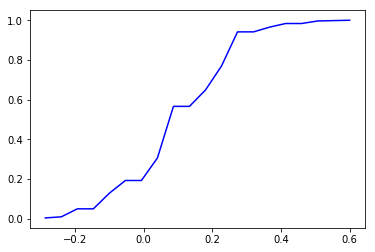

In [63]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=30)
clf.fit(X_train, y_train)
plot_cdf(clf)

### AdaDL85

train_score : 0.9233716475095786
n_trees : 10
test_score : 0.6412213740458015
Margins description : DescribeResult(nobs=522, minmax=(-0.8, 1.0), mean=-0.31417624521072796, variance=0.26286966561504915, skewness=1.1158834933065402, kurtosis=-0.2257354631685735)


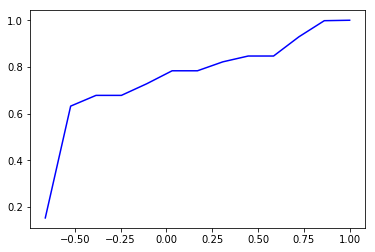

In [44]:
clf = AdaBoostClassifier(base_estimator=DL85Classifier(max_depth=depth), n_estimators=10)
clf.fit(X_train, y_train)
plot_cdf(clf)

### OptiBoost

train_score : 0.46096654275092935
n_trees : 10
test_score : 0.5373134328358209
Margins description : DescribeResult(nobs=269, minmax=(-1.609823385706478e-15, 1.609823385706478e-15), mean=-6.211470825505067e-17, variance=9.495144304849164e-31, skewness=0.06198052336870341, kurtosis=-1.2173344807331337)


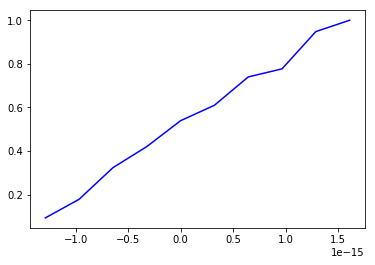

In [66]:
clf = DL85Booster(max_depth=depth, regulator=.5, model=MODEL_AGLIN)
clf.fit(X_train, y_train)
plot_cdf(clf)

### MDBoost

train_score : 0.9883720930232558
n_trees : 48
test_score : 0.9545454545454546
Margins description : DescribeResult(nobs=172, minmax=(-0.01484195876526534, 0.326690701060031), mean=0.14025010463377846, variance=0.0024160591936788866, skewness=-0.2613194653870319, kurtosis=1.654405088429808)


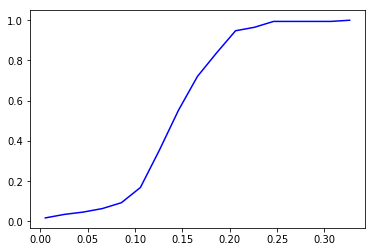

In [22]:
clf = DL85Boostera(max_depth=depth, regulator=50)
clf.fit(X_train, y_train)
plot_cdf(clf)

### LPBoost DEMIRIZ

train_score : 0.9591078066914498
n_trees : 68
test_score : 0.6865671641791045
Margins description : DescribeResult(nobs=269, minmax=(-0.030879804431962483, 0.3890209894773262), mean=0.0922040935531392, variance=0.00787600022801686, skewness=1.3753613110411504, kurtosis=1.5614713906216302)


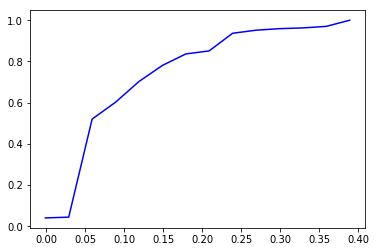

In [68]:
clf = DL85Booster(max_depth=depth, regulator=10, model=MODEL_DEMIRIZ)
clf.fit(X_train, y_train)
plot_cdf(clf)

### LPBoost RATSCH

train_score : 0.26022304832713755
n_trees : 4
test_score : 0.34328358208955223
Margins description : DescribeResult(nobs=269, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


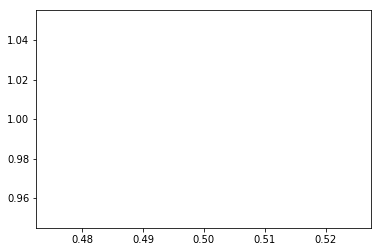

In [70]:
clf = DL85Booster(max_depth=depth, regulator=0.6, model=MODEL_RATSCH)
clf.fit(X_train, y_train)
plot_cdf(clf)

In [6]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
print("train_score :", accuracy_score(y_train, logisticRegr.predict(X_train)))
print("test_score :", accuracy_score(y_test, logisticRegr.predict(X_test)))

train_score : 0.9444444444444444
test_score : 0.7022900763358778


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Ver

train_score : 0.9099616858237548
n_trees : 9
test_score : 0.732824427480916
Margins description : DescribeResult(nobs=522, minmax=(-0.9999999999999999, 0.9999999999999999), mean=0.8199233716475094, variance=0.3283546966120266, skewness=-2.8644947804358902, kurtosis=6.205330347144455)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


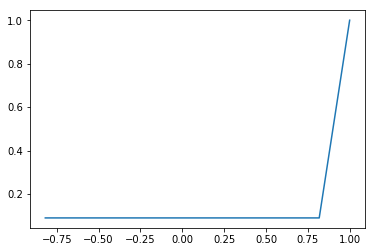

In [7]:
clf = DL85Boostera(base_estimator=LogisticRegression(max_iter=5, solver='liblinear'), max_depth=depth, regulator=20)
clf.fit(X_train, y_train)
plot_cdf(clf)

In [81]:
print("train_score :", accuracy_score(y_train, clf.predict(X_train)))
print("n_trees :", len(clf.estimators_))
print("test_score :", accuracy_score(y_test, clf.predict(X_test)))

In [85]:
accuracy_score(y_train, clf.predict(X_train))

0.715

In [86]:
accuracy_score(y_test, clf.predict(X_test))

0.6

train_score : 0.9118773946360154
n_trees : 9
test_score : 0.7022900763358778
Margins description : DescribeResult(nobs=522, minmax=(-1.0, 1.0), mean=0.8241805023414219, variance=0.19736399266382623, skewness=-2.8292635429154553, kurtosis=7.237314524447411)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


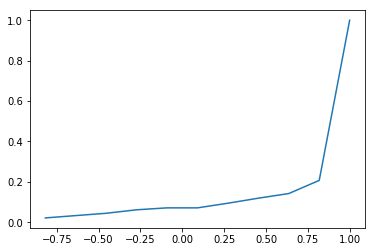

In [11]:
clf = AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=100, solver='liblinear'), n_estimators=9)
clf.fit(X_train, y_train)
plot_cdf(clf)